In [1]:
from sklearn.decomposition import PCA
import splitfolders
import zipfile,os
import numpy as np
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

In [2]:
local_zip = 'img.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

base_dir ='img'


In [3]:
splitfolders.ratio(base_dir, output=base_dir, ratio=(0.7,0.3))
 
train = os.path.join(base_dir, 'train')
val = os.path.join(base_dir, 'val')

Copying files: 420 files [00:03, 126.90 files/s]


In [4]:
os.listdir('img/train')
os.listdir('img/val')

['AAA',
 'ABI',
 'AFI',
 'AGH',
 'AIL',
 'ARL',
 'ASA',
 'BDL',
 'DIA',
 'DIO',
 'DRA',
 'EZA',
 'FAR',
 'FMR',
 'FRS',
 'GLA',
 'GPS',
 'HMA',
 'HZR',
 'IDR',
 'KDA',
 'MAA',
 'MAJ',
 'MFA',
 'MFH',
 'MGN',
 'MMF',
 'MRF',
 'MSA',
 'MZA',
 'MZB',
 'NIS',
 'QTH',
 'RCK',
 'RKS',
 'SHE',
 'SNN',
 'SVD',
 'SYH',
 'SYN',
 'train',
 'val',
 'YSS',
 'ZHT']

### Pre-Processing

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                rescale = 1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                rescale = 1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode = 'nearest')

In [6]:
train_generator = train_datagen.flow_from_directory(
        train,
        batch_size = 1,
        color_mode = 'grayscale',
        shuffle = False,
        class_mode = "categorical",
        target_size =  (100, 100))

test_generator = test_datagen.flow_from_directory(
        val,
        batch_size = 1,
        color_mode = 'grayscale',
        shuffle = False,
        class_mode = "categorical",
        target_size =  (100, 100))

Found 294 images belonging to 44 classes.
Found 126 images belonging to 44 classes.


### BPNN

In [7]:
X_train = train_generator[0][0][0].flatten()
for i in range(1, len(train_generator)):
    features = train_generator[i][0][0].flatten()
    X_train = np.vstack((X_train, features))

X_test = test_generator[0][0][0].flatten()
for i in range(1, len(test_generator)):
    features = test_generator[i][0][0].flatten()
    X_test = np.vstack((X_test, features))
    

In [8]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
Y_train = np.array(train_generator.labels)

In [9]:
pca=PCA(n_components=100, whiten=True)
pca.fit(X_train_scaled)
X_pca_train = pca.fit_transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)
pca_std = np.std(X_pca_train)

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    GaussianNoise(pca_std),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(42, activation='softmax')
])

In [11]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [12]:
history=model.fit(X_pca_train, Y_train, epochs=100, batch_size=4, validation_split=0.3, verbose=2)

Epoch 1/100
52/52 - 0s - loss: 3.8056 - accuracy: 0.0244 - val_loss: 5.4483 - val_accuracy: 0.0000e+00
Epoch 2/100
52/52 - 0s - loss: 2.4280 - accuracy: 0.4293 - val_loss: 5.9761 - val_accuracy: 0.0000e+00
Epoch 3/100
52/52 - 0s - loss: 1.7455 - accuracy: 0.6341 - val_loss: 6.2964 - val_accuracy: 0.0112
Epoch 4/100
52/52 - 0s - loss: 1.3953 - accuracy: 0.7415 - val_loss: 6.5366 - val_accuracy: 0.0112
Epoch 5/100
52/52 - 0s - loss: 1.0062 - accuracy: 0.8000 - val_loss: 6.6713 - val_accuracy: 0.0225
Epoch 6/100
52/52 - 0s - loss: 0.8105 - accuracy: 0.8634 - val_loss: 6.8354 - val_accuracy: 0.0225
Epoch 7/100
52/52 - 0s - loss: 0.6248 - accuracy: 0.9073 - val_loss: 6.9557 - val_accuracy: 0.0112
Epoch 8/100
52/52 - 0s - loss: 0.5364 - accuracy: 0.9024 - val_loss: 7.0932 - val_accuracy: 0.0112
Epoch 9/100
52/52 - 0s - loss: 0.5003 - accuracy: 0.9220 - val_loss: 7.2241 - val_accuracy: 0.0112
Epoch 10/100
52/52 - 0s - loss: 0.4626 - accuracy: 0.9122 - val_loss: 7.3159 - val_accuracy: 0.0112
E

Epoch 83/100
52/52 - 0s - loss: 0.1965 - accuracy: 0.9512 - val_loss: 9.8965 - val_accuracy: 0.0225
Epoch 84/100
52/52 - 0s - loss: 0.0636 - accuracy: 0.9756 - val_loss: 9.8430 - val_accuracy: 0.0112
Epoch 85/100
52/52 - 0s - loss: 0.1447 - accuracy: 0.9512 - val_loss: 9.7207 - val_accuracy: 0.0112
Epoch 86/100
52/52 - 0s - loss: 0.1780 - accuracy: 0.9512 - val_loss: 9.8406 - val_accuracy: 0.0225
Epoch 87/100
52/52 - 0s - loss: 0.1269 - accuracy: 0.9561 - val_loss: 9.8965 - val_accuracy: 0.0225
Epoch 88/100
52/52 - 0s - loss: 0.1105 - accuracy: 0.9659 - val_loss: 9.8061 - val_accuracy: 0.0225
Epoch 89/100
52/52 - 0s - loss: 0.1419 - accuracy: 0.9561 - val_loss: 9.7166 - val_accuracy: 0.0337
Epoch 90/100
52/52 - 0s - loss: 0.1639 - accuracy: 0.9463 - val_loss: 9.9154 - val_accuracy: 0.0449
Epoch 91/100
52/52 - 0s - loss: 0.1480 - accuracy: 0.9561 - val_loss: 10.0541 - val_accuracy: 0.0337
Epoch 92/100
52/52 - 0s - loss: 0.1685 - accuracy: 0.9317 - val_loss: 9.9106 - val_accuracy: 0.0337

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


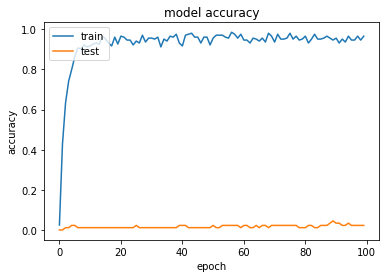

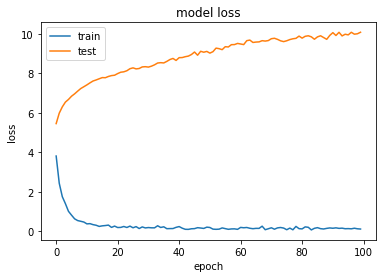

In [13]:
import matplotlib.pyplot as plt
print(history.history.keys())
# Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
import pandas as pd
result = pd.DataFrame(
    [history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy']],
    index=["loss","val_loss","accuracy","val_accuracy"],
    columns=[f'epoch_{num + 1}' for num in range(100)])

result

epoch_1   epoch_2   epoch_3   epoch_4   epoch_5   epoch_6  \
loss          3.805625  2.428004  1.745479  1.395299  1.006170  0.810532   
val_loss      5.448349  5.976146  6.296424  6.536618  6.671312  6.835421   
accuracy      0.024390  0.429268  0.634146  0.741463  0.800000  0.863415   
val_accuracy  0.000000  0.000000  0.011236  0.011236  0.022472  0.022472   

               epoch_7   epoch_8   epoch_9  epoch_10  ...   epoch_91  \
loss          0.624824  0.536442  0.500260  0.462553  ...   0.148036   
val_loss      6.955673  7.093194  7.224093  7.315912  ...  10.054066   
accuracy      0.907317  0.902439  0.921951  0.912195  ...   0.956098   
val_accuracy  0.011236  0.011236  0.011236  0.011236  ...   0.033708   

              epoch_92   epoch_93  epoch_94  epoch_95  epoch_96   epoch_97  \
loss          0.168508   0.141810  0.152500  0.123831  0.129403   0.119494   
val_loss      9.910630  10.071819  9.888276  9.974381  9.941544  10.072932   
accuracy      0.931707   0.951219  0.936585  0.965854  0.946341   0.946341   
val_accuracy  0.033708   0.022472  0.022472  0.033708  0.022472   0.022472   

              epoch_98  epoch_99  epoch_100  
loss          0.149134  0.120644   0.108216  
val_loss      9.976923  9.998441  10.075235  
accuracy      0.965854  0.946341   0.965854  
val_accuracy  0.022472  0.022472   0.022472  

[4 rows x 100 columns]